In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download preetviradiya/brian-tumor-dataset

100% 107M/107M [00:00<00:00, 147MB/s] 
100% 107M/107M [00:00<00:00, 135MB/s]


In [ ]:
! unzip brian-tumor-dataset.zip

Archive:  brian-tumor-dataset.zip
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1004).jpg  
  inflating: Brain Tumo

In [ ]:
import numpy as np
import pandas as pd
from time import strftime
import itertools
import random
import os
from os import walk
from os.path import join

In [ ]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import cv2

In [ ]:
import tensorflow as tf
from keras.layers import Dense, Activation, Dropout

In [ ]:
METADATA_PATH = 'metadata.csv'
TUMOR_IMG_PATH = 'Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/'
HEALTHY_IMG_PATH = 'Brain Tumor Data Set/Brain Tumor Data Set/Healthy/'
DF_DIR_PATH = 'working/brian-tumor-dataset/'
DF_PATH = DF_DIR_PATH + 'preprocessed-dataset.csv'
MODEL_PATH = DF_DIR_PATH + 'pretrained-model.csv'
CLASS_TUMOR = 1
CLASS_HEALTHY = 0
NOISE_FLOOR = 10;
WHITE_THRE = 30;
BLACK_THRE = 1;
TARGET_SIZE = 64;
TOTAL_INPUTS = TARGET_SIZE ** 2

In [ ]:
metadata_df = pd.read_csv(METADATA_PATH)
metadata_df.shape

(4600, 6)

In [ ]:
metadata_df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


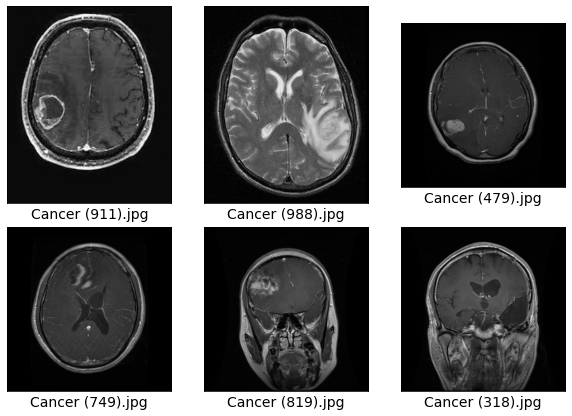

In [ ]:
fig = plt.figure(figsize=[10, 10])
fig.patch.set_facecolor('white')
for i in range(1, 7):
    plt.subplot(2, 3, i)
    rand_pick = random.randint(1, 1000)
    random_img = str(rand_pick)
    img = mpimg.imread(TUMOR_IMG_PATH + 'Cancer (' + random_img + ').jpg')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Cancer (' + str(random_img) + ').jpg', fontsize=14)
fig.subplots_adjust(hspace=-0.4)
plt.show()

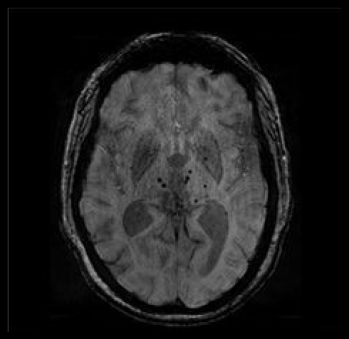

In [ ]:
EXAMPLE_IMG_PATH = HEALTHY_IMG_PATH + "Not Cancer  (122).jpg"
img1 = mpimg.imread(EXAMPLE_IMG_PATH)
fig = plt.figure(figsize=[6,6])
fig.patch.set_facecolor('black')
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
def rgb2gray(rgb_img):
    if rgb_img.ndim == 3:
        R, G, B = rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]
        output_img = 0.2989 * R + 0.5870 * G + 0.1140 * B
    else:
       output_img = rgb_img
    if output_img.max() < 1.1:
        output_img = output_img * 255
    return output_img

In [ ]:
print(f"Shape before: {img1.shape}")

Shape before: (228, 235, 3)


In [ ]:
img2 = rgb2gray(img1)
print(f"Shape after: {img2.shape}")

Shape after: (228, 235)


In [ ]:
def reduce_noise(noisy_img, noise_floor=NOISE_FLOOR):
    clean_img = np.array(noisy_img)
    clean_img[noisy_img < NOISE_FLOOR] = 0
    return clean_img

In [ ]:
print("Top left corner before:")
img2[:6, :6]

Top left corner before:


array([[109.989 ,  31.9968,  33.9966,  36.9963,  35.9964,  34.9965],
       [ 77.9922,   0.    ,   1.9998,   4.9995,   2.9997,   2.9997],
       [ 76.9923,   0.    ,   0.    ,   2.9997,   0.9999,   0.    ],
       [ 81.9918,   3.9996,   4.9995,   6.9993,   3.9996,   3.9996],
       [ 78.9921,   0.    ,   0.    ,   1.9998,   0.    ,   0.    ],
       [ 80.9919,   1.9998,   0.9999,   2.9997,   0.    ,   0.    ]])

In [ ]:
img3 = reduce_noise(img2)
print("Top left corner after:")
img3[:6, :6]

Top left corner after:


array([[109.989 ,  31.9968,  33.9966,  36.9963,  35.9964,  34.9965],
       [ 77.9922,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 76.9923,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 81.9918,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 78.9921,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 80.9919,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ]])

In [ ]:
def remove_white_borders(img_with_borders, threshold=WHITE_THRE):
    # left
    if np.mean(img_with_borders[:, 0]) > threshold:
        img_with_borders[:, 0] = 0;
    # right
    if np.mean(img_with_borders[:, -1]) > threshold:
        img_with_borders[:, -1] = 0;
    # top
    if np.mean(img_with_borders[0, :]) > threshold:
        img_with_borders[0, :] = 0;
    # bottom
    if np.mean(img_with_borders[-1, :]) > threshold:
        img_with_borders[-1, :] = 0;
    return img_with_borders

In [ ]:
print("Top left corner before:")
img3[:6, :6]

Top left corner before:


array([[109.989 ,  31.9968,  33.9966,  36.9963,  35.9964,  34.9965],
       [ 77.9922,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 76.9923,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 81.9918,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 78.9921,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ],
       [ 80.9919,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ]])

In [ ]:
img4 = remove_white_borders(img3)
print("Top left corner after:")
img4[:6, :6]

Top left corner after:


array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
def remove_black_padding(img_with_padding, threshold=BLACK_THRE):
    # Sides
    vert_mean = np.mean(img_with_padding, axis=0)
    vert_map = vert_mean > BLACK_THRE;
    vert_matches = np.where(vert_map == True)
    img_no_padding = img_with_padding[:, vert_matches[0][0]:vert_matches[0][-1]]
    # Top & bottom
    hori_mean = np.mean(img_no_padding, axis=1)
    hori_map = hori_mean > BLACK_THRE;
    hori_matches = np.where(hori_map == True)
    img_no_padding = img_no_padding[hori_matches[0][0]:hori_matches[0][-1], :]
    return img_no_padding

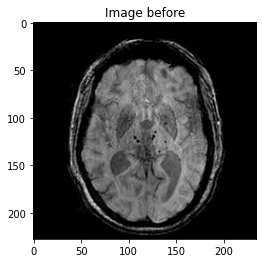

In [ ]:
fig = plt.figure(figsize=[4, 4])
fig.patch.set_facecolor('white')
plt.title("Image before")
plt.imshow(img4, cmap="gray")
plt.show()

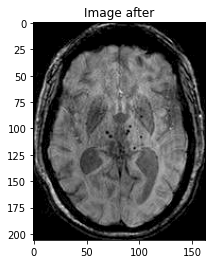

In [ ]:
img5 = remove_black_padding(img4)
fig = plt.figure(figsize=[4, 4])
fig.patch.set_facecolor('white')
plt.title("Image after")
plt.imshow(img5, cmap="gray")
plt.show()

In [ ]:
def square_image(rect_img):
    X, Y = rect_img.shape
    if X != Y:
        if X > Y:
            out_img = np.zeros((X, X))
            offset = int(np.ceil((X-Y) / 2))
            out_img[:, offset : (offset + Y)] = rect_img
        else:
            out_img = np.zeros((Y, Y))
            offset = int(np.ceil((Y-X) / 2))
            out_img[offset : (offset + X), :] = rect_img
        return out_img
    else:
        return rect_img

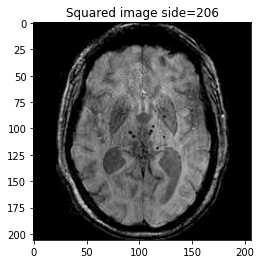

In [ ]:
img6 = square_image(img5)
fig = plt.figure(figsize=[4, 4])
fig.patch.set_facecolor('white')
plt.imshow(img6, cmap="gray")
plt.title(f"Squared image side={img6.shape[0]}")
plt.show()

In [ ]:
img7 = cv2.resize(img6, dsize=(TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_CUBIC)

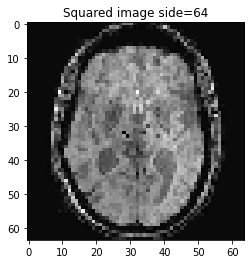

In [ ]:
fig = plt.figure(figsize=[4, 4])
fig.patch.set_facecolor('white')
plt.imshow(img7, cmap="gray")
plt.title(f"Squared image side={img7.shape[0]}")
plt.show()

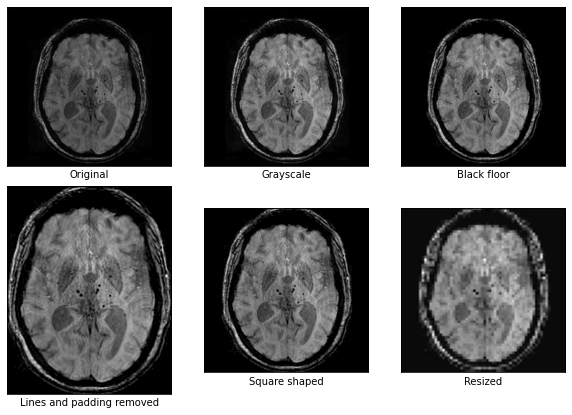

In [ ]:
fig = plt.figure(figsize=[10, 10])
fig.patch.set_facecolor('white')
plt.subplot(2, 3, 1)
plt.imshow(img1)
plt.xticks([])
plt.yticks([])
plt.xlabel("Original")

plt.subplot(2, 3, 2)
plt.imshow(img2, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.xlabel("Grayscale")

plt.subplot(2, 3, 3)
plt.imshow(img3, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.xlabel("Black floor")

plt.subplot(2, 3, 4)
plt.imshow(img5, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.xlabel("Lines and padding removed")

plt.subplot(2, 3, 5)
plt.imshow(img6, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.xlabel("Square shaped")

plt.subplot(2, 3, 6)
plt.imshow(img7, cmap="gray")
plt.xlabel("Resized")
plt.xticks([])
plt.yticks([])
fig.subplots_adjust(hspace=-0.4)
plt.show()

In [ ]:
def preprocesss_img(input_img):
    output_img = rgb2gray(input_img)
    output_img = reduce_noise(output_img)
    output_img = remove_white_borders(output_img)
    output_img = remove_black_padding(output_img)
    output_img = square_image(output_img)
    output_img = cv2.resize(output_img, dsize=(TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_LINEAR)
    return output_img

In [ ]:
features = np.zeros((1, TARGET_SIZE ** 2))
target = np.array([])
debug=1
# Fill with tumor images
for root, dirnames, filenames in walk(TUMOR_IMG_PATH):
    n_total = len(filenames)
    n = 1
    for filename in filenames:
        file_path = join(root, filename)
        if n % 200 == 0:
            print(f"File {n}/{n_total}\t {filename}")
        n = n + 1
        img = mpimg.imread(file_path)
        img = preprocesss_img(img)
        features = np.vstack([features, np.reshape(img, -1)])
        target = np.append(target, CLASS_TUMOR)
features = features[1:, :]

File 200/2513	 Cancer (1392).jpg
File 400/2513	 Cancer (1287).jpg
File 600/2513	 Cancer (1021).jpg
File 800/2513	 Cancer (1215).jpg
File 1000/2513	 Cancer (75).jpg
File 1200/2513	 Cancer (2323).jpg
File 1400/2513	 Cancer (1971).jpg
File 1600/2513	 Cancer (189).jpg
File 1800/2513	 Cancer (332).jpg
File 2000/2513	 Cancer (480).jpg
File 2200/2513	 Cancer (1910).jpg
File 2400/2513	 Cancer (1431).jpg


In [ ]:
for root, dirnames, filenames in walk(HEALTHY_IMG_PATH):
    n_total = len(filenames)
    n = 1
    for filename in filenames:
        file_path = join(root, filename)
        if n % 200 == 0:
            print(f"File {n}/{n_total}\t {filename}")
        n = n + 1
        img = mpimg.imread(file_path)
        img = preprocesss_img(img)
        features = np.vstack([features, np.reshape(img, -1)])
        target = np.append(target, CLASS_HEALTHY)

File 200/2087	 Not Cancer  (1652).jpg
File 400/2087	 Not Cancer  (699).jpg
File 600/2087	 Not Cancer  (696).jpg
File 800/2087	 Not Cancer  (1800).jpg
File 1000/2087	 Not Cancer  (1223).jpg
File 1200/2087	 Not Cancer  (1128).jpg
File 1400/2087	 Not Cancer  (883).jpg
File 1600/2087	 Not Cancer  (1211).jpg
File 1800/2087	 Not Cancer  (1415).jpg
File 2000/2087	 Not Cancer  (744).jpg


In [ ]:
df = pd.DataFrame(features)
df["target"] = target

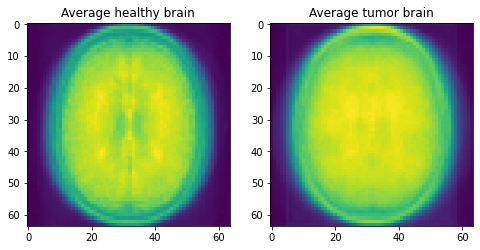

In [ ]:
average_healthy_brain = np.array(df[df["target"] == CLASS_HEALTHY].drop("target", axis=1).mean()).reshape(64,64)
average_tumor_brain = np.array(df[df["target"] == CLASS_TUMOR].drop("target", axis=1).mean()).reshape(64,64)
plt.figure(figsize=[8, 4])
plt.subplot(1,2,1)
plt.imshow(average_healthy_brain)
plt.title('Average healthy brain')
plt.subplot(1,2,2)
plt.imshow(average_tumor_brain)
plt.title('Average tumor brain')
plt.show()

In [ ]:
target = df["target"]
features = df.drop("target", axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=10)

In [ ]:
VALIDATION_SIZE = 600
x_val = x_train[:VALIDATION_SIZE]
y_val = y_train[:VALIDATION_SIZE]

In [ ]:
model_1 = Sequential([
    Dense(units=256, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    Dense(units=128, activation='relu', name='m1_hidden2'),
    Dense(units=64, activation='relu', name='m1_hidden3'),
    Dense(units=16, activation='relu', name='m1_hidden4'),
    Dense(units=2, activation='softmax', name='m1_output')
])
asdf = tf.keras.optimizers.Adam
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 256)               1048832   
                                                                 
 m1_hidden2 (Dense)          (None, 128)               32896     
                                                                 
 m1_hidden3 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden4 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 2)                 34        
                                                                 
Total params: 1,091,058
Trainable params: 1,091,058
Non-trainable params: 0
_________________________________________________________________


In [ ]:
samples_per_batch = 100
n_epochs = 60

In [ ]:
model_1.fit(x=x_train, y=y_train,
            epochs=n_epochs,
            batch_size=samples_per_batch,
            validation_data=(x_val, y_val))

Epoch 1/60
42/42 [==============================] - 1s 27ms/step - loss: 0.2166 - accuracy: 0.9171 - val_loss: 0.0735 - val_accuracy: 0.9833
Epoch 2/60
42/42 [==============================] - 1s 26ms/step - loss: 0.0827 - accuracy: 0.9758 - val_loss: 0.0497 - val_accuracy: 0.9917
Epoch 3/60
42/42 [==============================] - 1s 26ms/step - loss: 0.0722 - accuracy: 0.9814 - val_loss: 0.0413 - val_accuracy: 0.9933
Epoch 4/60
42/42 [==============================] - 1s 30ms/step - loss: 0.1059 - accuracy: 0.9652 - val_loss: 0.1499 - val_accuracy: 0.9417
Epoch 5/60
42/42 [==============================] - 2s 40ms/step - loss: 0.1187 - accuracy: 0.9563 - val_loss: 0.0466 - val_accuracy: 0.9867
Epoch 6/60
42/42 [==============================] - 2s 41ms/step - loss: 0.0425 - accuracy: 0.9896 - val_loss: 0.0293 - val_accuracy: 0.9933
Epoch 7/60
42/42 [==============================] - 1s 31ms/step - loss: 0.0408 - accuracy: 0.9903 - val_loss: 0.0507 - val_accuracy: 0.9883
Epoch 8/60
42

In [ ]:
test_loss, test_accuracy = model_1.evaluate(x_test, y_test)
print(f"loss: {test_loss:0.3}\t accuracy: {test_accuracy:0.1%}")

15/15 [==============================] - 0s 8ms/step - loss: 0.3033 - accuracy: 0.9391
loss: 0.303	 accuracy: 93.9%


In [ ]:
predict_x_test = model_1.predict(x_test)
classes_x_test = np.argmax(predict_x_test, axis=1)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=classes_x_test)

15/15 [==============================] - 1s 12ms/step


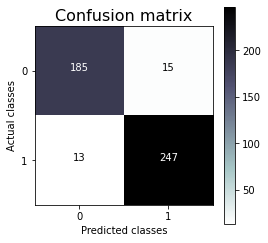

In [ ]:
plt.figure(figsize=[4, 4])
plt.imshow(conf_matrix, cmap="bone_r")
plt.title("Confusion matrix", fontsize=16)
plt.ylabel("Actual classes")
plt.xlabel("Predicted classes")
tick_marks = np.arange(2)
plt.yticks(tick_marks, [0,1])
plt.xticks(tick_marks, [0,1])
plt.colorbar()
for i, j in itertools.product(range(2), range(2)):
    plt.text(j, i, conf_matrix[i][j], horizontalalignment="center",
             color="white" if conf_matrix[i][j] > 100 else "black")
plt.show()